In [1]:
import argparse
import os
import sys

from astropy.io import fits

import pint.models as models
import pint.fermi_toas as fermi
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord

import scipy.optimize as op
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt

import pint.fitter as fitter
import pint.toa as toa
import pint.derived_quantities as pd
import pint.residuals as pr
import pint.simulation as ps
from pint.utils import FTest
from pint.plot_utils import phaseogram
from pint.eventstats import hmw

import astropy.time
from astropy.time import TimeDelta

import copy
from astropy.visualization import quantity_support
from pint.fitter import MaxiterReached, StepProblem

import pint.logging
from loguru import logger as log

pint.logging.setup(level="INFO")

1

In [2]:
import pint.scripts.event_optimize as eo
from pint.scripts.event_optimize import emcee_fitter

In [3]:
# Functions to make the gamma-ray TOAs
from pint.scripts.event_optimize import read_gaussfitfile, profile_likelihood

def marginalize_over_phase(
    phases,
    template,
    weights=None,
    resolution=1.0 / 1024,
    minimize=True,
    fftfit=False,
    showplot=False,
    lophs=0.0,
    hiphs=1.0,
):
    """Find the best fit pulse profile

    a pulse profile comprised of combined photon phases.  A maximum
    likelood technique is used.  The shift and the max log likehood
    are returned.  You probably want to use "minimize" rathre than
    "fftfit" unless you are only sampling very close to your known min.
    """
    ltemp = len(template)
    xtemp = np.arange(ltemp) * 1.0 / ltemp
    if minimize:
        phs, like, _ = marginalize_over_phase(
            phases,
            template,
            weights,
            resolution=1.0 / 64,
            minimize=False,
            showplot=showplot,
        )
        phs = 1.0 - phs[0] / ltemp
        hwidth = 0.03
        lophs, hiphs = phs - hwidth, phs + hwidth
        result = op.minimize(
            neg_prof_like,
            [phs],
            args=(xtemp, phases, template, weights),
            bounds=[[lophs, hiphs]],
        )
        return ltemp - result["x"] * ltemp, -result["fun"], _
    if fftfit:
        deltabin = 3
        h, x = np.histogram(
            phases.astype(np.float64), ltemp, range=[0.0, 1.0], weights=weights
        )
        s, es, snr, esnr, b, errb, ngood = measure_phase(h, template, rotate_prof=False)
        # s is in bins based on the template size
        lophs = (ltemp - s - deltabin) / float(ltemp)  # bins below
        if lophs < 0.0:
            lophs += 1.0
        hiphs = lophs + 2.0 * deltabin / float(ltemp)  # bins above
    dphss = np.arange(lophs, hiphs, resolution)
    trials = phases.astype(np.float64) + dphss[:, np.newaxis]
    # ensure that all the phases are within 0-1
    trials[trials > 1.0] -= 1.0
    probs = np.interp(trials, xtemp, template, right=template[0])
    if weights is None:
        lnlikes = (np.log(probs)).sum(axis=1)
    else:
        lnlikes = (np.log(weights * probs + 1.0 - weights)).sum(axis=1)
    if showplot:
        plt.plot(dphss, lnlikes)
        plt.xlabel("Pulse Phase")
        plt.ylabel("Log likelihood")
        plt.show()
    return [ltemp - dphss[lnlikes.argmax()] * ltemp], lnlikes.max(), dphss[lnlikes.argmax()]

# Easy way to group the photons into intervals to sum over for TOAs
def get_photon_select(mjds, targetMJD, deltaMJD):
    return np.fabs(mjds - targetMJD) < deltaMJD


def profile_likelihood(phs, phases, xvals, template, weights=None):
    """The log likelihood event phases to match a template assuming a phase
    offset of phs.  The template and xvals must wrap and therefore go
    from 0-1.  Likelihood is calculated as per eqn 2 in Pletsch &
    Clark 2015.  Tha calculation will work over an array of input
    phases if you use array braodcasting:  phases[:,np.newaxis]
    """
    phss = (phases.astype(np.float64) + phs) % 1.0 # Ensure [0-1)
    probs = np.interp(phss, xvals, template, period=1.0) #### THIS IS DIFFERENT THAN THE PROFILE LIKELIHOOD IN
    #probs = np.interp(phss, xvals, template, right=template[0]) #### EVENT_OPTIMIZE
    if weights is None:
        return np.log(probs).sum(axis=-1)
    else:
        return np.log(weights*probs + 1.0-weights).sum(axis=-1)

def get_TOA(events, phs0, dphs, xvals, template,
            ntrials=501, weights=None, plot=True):
    """Return the measured phase and error (assuming gaussian errors) of
    phase-folded events fit to a template.  Initial guess phase (phs0)
    and +/-dphs range to search over must be supplied.
    """
    # phase trials
    phs_trials = np.linspace(phs0-dphs, phs0+dphs, ntrials)
    # log-likelihood trials for phase
    ll = profile_likelihood(phs_trials[:,np.newaxis],
                            events, xvals, template, weights)
    # Now "fit" a gaussian and determine sigma by calculating
    # the 2nd moment of the likelihood
    like = np.exp(ll-ll.max())
    X = phs_trials
    mn = np.sum(X * like) / np.sum(like)
    sigma = np.sqrt(np.abs(np.sum((X-mn)**2 * like) / np.sum(like)))
    if plot:
        plt.plot(X, like, '.', label = 'Like')
        fit = ss.norm.pdf(X, mn, sigma)
        plt.plot(X, fit/fit.max(), '-', label = 'Fit')
        plt.legend()
        plt.show()
    return mn, sigma

def get_TOAs_marginalize(phss, weights, template, bins):
    xvals = np.linspace(0.0,1.0,bins)
    _,_,p = marginalize_over_phase(phss,template, weights, minimize=False, fftfit=False,showplot=False
        )
    mn, sigma = get_TOA(phss, p, 0.05, xvals, template, ntrials=bins, weights = weights, plot=False)
    return mn, sigma

def toas_to_timfile(ts, model, template, weights, bins, ntoas, filename=None):
    '''
    ts: The photon data that will be used to generate TOAs
    model: The timing model
    template: The gaussian template
    weights: The photon weights
    bins: The number of bins used
    deltaMJD: The delta mjd range used to select the events around a central mjd
    '''
    mjds = ts.get_mjds().value
    phss = model.phase(ts).frac.value % 1
    phss = phss.astype(np.float64)
    p0 = 1/model.F0.value

    gtoas = []
    mn = []
    
    deltaMJD = int((mjds[-1]-mjds[0])/ntoas)
    
    # To select events around a targetMJD, calculate a precise phase and TOA
    target_mjds = np.arange(int(mjds[0]+deltaMJD/2),int(mjds[-1]),deltaMJD)

    for i in target_mjds:
        sel = get_photon_select(mjds, i, deltaMJD/2)
        if len(mjds[sel] != 0):
            TOA_weighted = np.average(mjds[sel],weights=weights[sel])
            a, sigma = get_TOAs_marginalize(phss[sel],weights[sel],template,bins)
            mn.append(a)
            gtoas.append(toa.TOA(TOA_weighted, sigma*p0*1e6,freq=9999.9,obs='Geocenter',name='event'))

    gtoas = toa.get_TOAs_list(gtoas,ephem=model.EPHEM.value)
    gtoas.compute_pulse_numbers(model)
    #orig_phases = model.phase(faketoas).frac

    # Set those TOAs to zero residuals 
    ps.zero_residuals(gtoas,model)
    residuals = pr.Residuals(toas=gtoas,model=model)
    p0 = (1/residuals.get_PSR_freq(calctype="taylor")).decompose()

    #adjusted_phases = model.phase(faketoas).frac

    # Computes the phase offset of the zero residual TOAs and shifts the TOAs to phase 0.0 (Or close to 0.0)
    phases = model.phase(gtoas).frac
    dt = TimeDelta((phases*p0))+ TimeDelta((mn*p0))
    gtoas.adjust_TOAs(-dt)
    gtoas.table.remove_column('pulse_number')

    #final_phases = model.phase(faketoas).frac

    # Writes the fake TOAs to a file
    if filename:
        gtoas.write_TOA_file(filename+'.tim')

    return gtoas

def load_events_weights(eventfile,model,weightcol,minMJD,maxMJD,minWeight,usepickle=False):
    wgtexp = 0.0
    if "ELONG" in model.params:
        tc = SkyCoord(
            model.ELONG.quantity,
            model.ELAT.quantity,
            frame="barycentrictrueecliptic",
        )
    else:
        tc = SkyCoord(model.RAJ.quantity, model.DECJ.quantity, frame="icrs")

    target = tc if weightcol == "CALC" else None

    # TODO: make this properly handle long double
    ts = None
    if usepickle:
        try:
            ts = toa.load_pickle(eventfile)
            mjds = ts.get_mjds().value
            #ts = ts[[mjds > minMJD] and [mjds < maxMJD]]
            ts = ts[mjds > minMJD]
            mjds = mjds[mjds > minMJD]
            ts = ts[mjds < maxMJD]
        except IOError:
            pass
    if ts is None:
        ts = fermi.get_Fermi_TOAs(eventfile,weightcolumn=weightcol,targetcoord=target,minweight=minWeight,minmjd=minMJD,maxmjd=maxMJD,ephem="DE421",planets=False)
        ts.filename = eventfile
        # FIXME: writes to the TOA directory unconditionally
        try:
            toa.save_pickle(ts)
        except IOError:
            pass

    if weightcol is not None:
        if weightcol == "CALC":
            weights = np.asarray([float(x["weight"]) for x in ts.table["flags"]])
            log.info(
                "Original weights have min / max weights %.3f / %.3f"
                % (weights.min(), weights.max())
            )
            # Rescale the weights, if requested (by having wgtexp != 0.0)
            if wgtexp != 0.0:
                weights **= wgtexp
                wmx, wmn = weights.max(), weights.min()
                # make the highest weight = 1, but keep min weight the same
                weights = wmn + ((weights - wmn) * (1.0 - wmn) / (wmx - wmn))
            for ii, x in enumerate(ts.table["flags"]):
                x["weight"] = str(weights[ii])
        weights = np.asarray([float(x["weight"]) for x in ts.table["flags"]])
        log.info(
            "There are %d events, with min / max weights %.3f / %.3f"
            % (len(weights), weights.min(), weights.max())
        )
    else:
        weights = None
        log.info("There are %d events, no weights are being used." % ts.ntoas)
        
    ts = ts[weights > minWeight]
    weights = weights[weights > minWeight]
    
    log.info(
        "There are %d events, with min / max weights %.3f / %.3f"
        % (len(weights), weights.min(), weights.max())
    )
    return ts, weights
                
def phaseogram_updated(
    mjds_in,
    phases,
    weights=None,
    title=None,
    bins=100,
    rotate=0.0,
    size=5,
    alpha=0.25,
    width=6,
    maxphs=2.0,
    plotfile=None,
    alpha_wgts=None,
):
    """Make a nice 2-panel phaseogram
    Makes a phaseogram of photons with phases, with a point for each photon that can
    have a transparency determined by an array of weights.
    Parameters
    ----------
    mjds_in : array or astropy.units.Quantity or astropy.time.Time
        Assumes units of days if bare numerical array, otherwise
        will convert Quantity or Time into days.
    phases : array
        Phases for each photon, assumes range is [0,1)
    """
    # If mjds_in is a Time() then pull out the MJD values and make a quantity
    if type(mjds_in) == astropy.time.core.Time:
        mjds = mjds_in.mjd * u.d
    # If mjds_in have no units, assume days
    elif type(mjds_in) != astropy.units.quantity.Quantity:
        mjds = mjds_in * u.d
    else:
        mjds = mjds_in

    years = (mjds.to(u.d).value - 51544.0) / 365.25 + 2000.0
    phss = phases + rotate
    phss[phss >= 1.0] -= 1.0
    plt.figure(figsize=(width, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0))
    ax2 = plt.subplot2grid((3, 1), (1, 0), rowspan=2)
    wgts = None if weights is None else np.concatenate((weights, weights))
    h, x, p = ax1.hist(
        np.concatenate((phss, phss + 1.0)),
        int(maxphs * bins),
        range=[0, maxphs],
        weights=wgts,
        color="k",
        histtype="step",
        fill=False,
        lw=2,
    )
    ax1.set_xlim([0.0, maxphs])  # show 1 or more pulses
    ax1.set_ylim([0.0, 1.1 * h.max()])
    if weights is not None:
        ax1.set_ylabel("Weighted Counts")
    else:
        ax1.set_ylabel("Counts")
    if title is not None:
        ax1.set_title(title)
    if weights is None:
        ax2.scatter(phss, mjds, s=size, color="k", alpha=alpha)
        ax2.scatter(phss + 1.0, mjds, s=size, color="k", alpha=alpha)
    else:
        if alpha_wgts is not None:
            #colarray = np.hstack((np.zeros((len(alpha_wgts),3)),alpha_wgts.reshape(len(alpha_wgts),1)))
            colarray = np.zeros((len(alpha_wgts),4)); colarray[:,3] = alpha_wgts
            ax2.scatter(phss, mjds, s=size, color=colarray)
            ax2.scatter(phss + 1.0, mjds, s=size, color=colarray)
        else:
            colarray = np.array([[0.0, 0.0, 0.0, w] for w in weights])
            ax2.scatter(phss, mjds, s=size, color=colarray)
            ax2.scatter(phss + 1.0, mjds, s=size, color=colarray)
    ax2.set_xlim([0.0, maxphs])  # show 1 or more pulses
    ax2.set_ylim([mjds.min().value, mjds.max().value])
    ax2.set_ylabel("MJD")
    ax2.get_yaxis().get_major_formatter().set_useOffset(False)
    ax2.get_yaxis().get_major_formatter().set_scientific(False)
    ax2r = ax2.twinx()
    ax2r.set_ylim([years.min(), years.max()])
    ax2r.set_ylabel("Year")
    ax2r.get_yaxis().get_major_formatter().set_useOffset(False)
    ax2r.get_yaxis().get_major_formatter().set_scientific(False)
    ax2.set_xlabel("Pulse Phase")
    plt.tight_layout()
    if plotfile is not None:
        plt.savefig(plotfile)
        plt.close()
    else:
        plt.show()

In [4]:
def phase_wrap(model,ts):
    res = pr.Residuals(ts,model)
    resids = res.phase_resids
    if np.diff(resids).max() > 0.5:
        log.warning('Phase wrap detected')
        for i in range(np.where(np.diff(resids)==np.diff(resids).max())[0][0]+1,len(ts)):
            ts['delta_pulse_number'][i] += -1.0
        res = pr.Residuals(ts,model)
    return res, ts

def get_amp_ind(residuals,nwaves,res_type=None,show_plot=False):
    if res_type == 'time':
        residuals = residuals.time_resids.to_value(u.s)
        title=f'FFT of Time Residuals'
    if res_type == 'phase':
        residuals = residuals.phase_resids
        title=f'FFT of Phase Residuals'
    a = np.fft.fft(np.asarray(residuals.astype(np.float64)))
    psd = np.abs(a)**2
    freqs = np.fft.fftfreq(len(psd),d=1/(2*len(psd)))
    lim = int(len(psd)/2)
#     xdata = freqs[1:lim]
#     ydata = psd[1:lim]
    xdata = freqs[1:nwaves+1]
    ydata = psd[1:nwaves+1]

    def powlaw(x, a, b) :
        return a * np.power(x, b)
    
    popt,pcov = op.curve_fit(powlaw,xdata,ydata)
    log.info(f'The amplitude is {popt[0]} and the spectral index is {popt[1]}')
    if show_plot:
        plt.figure(figsize=(15,10))
        plt.plot(freqs[1:lim], popt[0]*np.power(freqs[1:lim],popt[1]),'--',label='Power-law Fit')
        plt.plot(freqs[1:lim],psd[1:lim],'x')
        plt.title(f'{title}', fontsize = 24)
        plt.xscale('log')
        plt.yscale('log')
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Power Spectral Density',fontsize = 16)
        plt.xlabel('Sample Frequency',fontsize = 16)
        plt.grid('True')
    
#     return [np.log10(popt[0]),popt[1]]
    return popt

In [33]:
eventfile = 'J2028_0.5weight.pickle.gz'
# eventfile = 'J2028.pickle.gz'
parfile = 'J2028_wrn.par'
gaussfile = '2028.gaussians'
weightcol = '4FGL J2028.3+3331'
# eventfile = 'J0633_Fermi_GEO_srcprob.fits.pickle.gz'
# parfile = 'J0633+0632_wrn.par'
# gaussfile = 'J0633_2.gaussians'
# weightcol = '4FGL J0633.7+0632'

minWeight = 0.1
nbins = 256
minMJD = 54680.0
maxMJD = 60000.0
nToas = 14*4 # Number of TOAs
maxiter = 10
alpha = 2

nwaves = 7

In [34]:
model = models.get_model(parfile)
gtemplate = read_gaussfitfile(gaussfile,nbins)
gtemplate /= gtemplate.mean()
gtemplate = gtemplate.astype(np.float64)

Text(0.5, 1.0, 'Example Template')

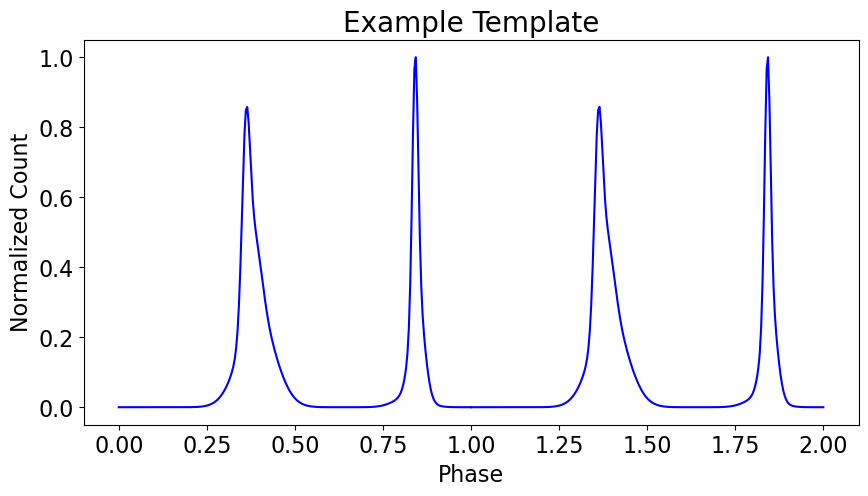

In [32]:
x = np.linspace(0,1,256)
y = np.roll(gtemplate,100)/gtemplate.max()
plt.figure(figsize=(10,5))
plt.plot(x,y,color='b')
plt.plot(x+1.0,y,color='b')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Phase',fontsize=16)
plt.ylabel('Normalized Count',fontsize=16)
plt.title('Example Template',fontsize=20)

In [35]:
ts, weights = load_events_weights(eventfile,model,weightcol,minMJD,maxMJD,minWeight,usepickle=True)

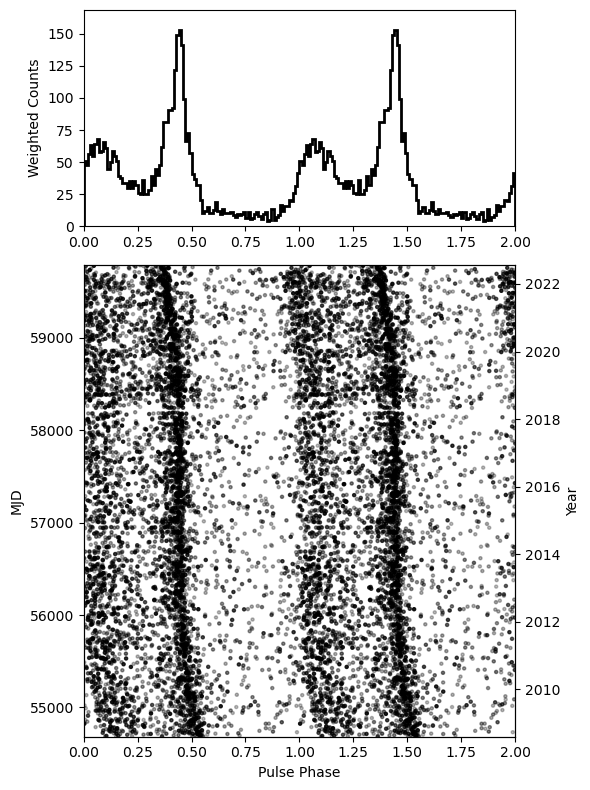

In [36]:
log.info('Generating Prefit Phaseogram')
mjds = ts.table["tdbld"].data
phases = model.phase(ts).frac.value % 1
alpha_wgts = np.power(weights,alpha)
phaseogram_updated(mjds,phases,weights,bins=100,plotfile=None,alpha_wgts=alpha_wgts)

In [38]:
toas = toas_to_timfile(ts,model,gtemplate,weights,nbins,nToas)
toas.write_TOA_file('J2028_56TOAs.tim')

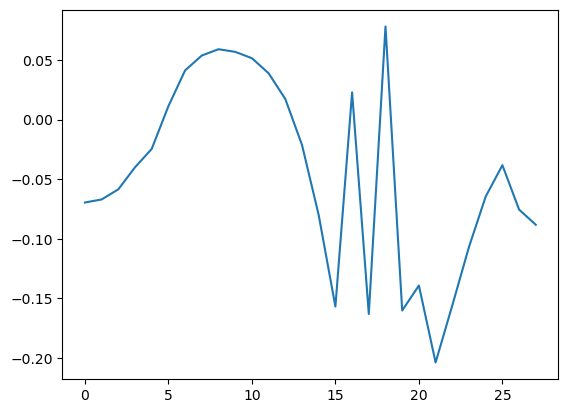

In [13]:
init_resids = pr.Residuals(toas,model)
# p = get_amp_ind(init_resids,nwaves,res_type='time',show_plot=True)
# print(p)
# plt.plot(init_resids.time_resids)

In [13]:
# Wave fitter to get the initial coefficient values
def wave_fitter(model,ts,nwaves=1,show_plot=False):
    '''
    Does a iterative fit of a no red noise model adding waves with each iteration and compares the fitted model with the previous iteration using the F-test
    '''
    import copy
    
    def res_plot(mjds,residuals,ts):
        quantity_support()
        plt.figure(figsize=(16,9))
        plt.yticks(fontsize=16)
        plt.xticks(fontsize=16)
        plt.ylabel('Residuals',fontsize = 16)
        plt.xlabel('MJDs',fontsize = 16)
        plt.errorbar(mjds,residuals.time_resids,yerr=ts.get_errors(),fmt='+')
        plt.title('Initial Residuals',fontsize=20)
        plt.grid()
        plt.show()
    
    ts.compute_pulse_numbers(model)
    mjds = ts.get_mjds()
    residuals, ts = phase_wrap(model,ts)
#     PM_values = []
#     PM_values.append([0,model.PMRA.value,model.PMRA.uncertainty_value,model.PMDEC.value,model.PMDEC.uncertainty_value])
#     PM_values.append([0,model.PMELONG.value,model.PMELONG.uncertainty_value,model.PMELAT.value,model.PMELAT.uncertainty_value])
    if show_plot:
        res_plot(mjds,residuals,ts)
    tspan = mjds[-1]-mjds[0]
    for i in range(1,nwaves+1):
        log.info(f'Fitting {i} waves')
        # Setting up the waves within the model
        if i == 1:
            fit_model = copy.deepcopy(model)
            freq = 1/tspan
            fit_model.add_component(models.WaveX())
            fit_model.WXFREQ_0001.value = freq
        else:
            fit_model = copy.deepcopy(red_fitter.model)
            freq = i/tspan
            fit_model.components['WaveX'].add_wavex_component(freq,i,frozen=False)
        # Running the fitter
        try:
            red_fitter = fitter.Fitter.auto(ts,fit_model)
            red_fitter.fit_toas()
            red_fitter.update_model()
            red_fitter.model.CHI2.value = red_fitter.resids.chi2
#             PM_values.append([i,red_fitter.model.PMRA.value,red_fitter.model.PMRA.uncertainty_value,red_fitter.model.PMDEC.value,red_fitter.model.PMDEC.uncertainty_value])   
#             PM_values.append([i,red_fitter.model.PMELONG.value,red_fitter.model.PMELONG.uncertainty_value,red_fitter.model.PMELAT.value,red_fitter.model.PMELAT.uncertainty_value])   
            if show_plot:
                red_fitter.plot()
        except (MaxiterReached, StepProblem) as e:
            log.warning(f'{e} encountered when fitting {i} waves')
            continue
            
#         # Stop criteria
#         if red_fitter.resids_init.rms_weighted()/red_fitter.resids.rms_weighted() < 3.0:
#             log.warning(f'The ratio of pre-fit and post-fit rms is less than 3.0 at {i} waves')
#             break
    return residuals, red_fitter

In [14]:
red_model = copy.deepcopy(model)
for i in red_model.free_params:
    if not i.startswith('F'):
        red_model[i].frozen=True
init_resids, f = wave_fitter(red_model, toas, nwaves, show_plot=False)

WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:345 UserWarning: Frequency resolution is greater than 1/yr
WARNING  (pint.logging                  ): /users/dbhakta/git/PINT/src/pint/models/wavex.py:34

In [ ]:
D, params, units = f.model.designmatrix(toas)

In [27]:
# Extract fourier coefficients from the fitter
wave_freqs, init_coeffs = [],[]
wxfreq = f.model.components['WaveX'].get_prefix_mapping_component('WXFREQ_')
wxsin = f.model.components['WaveX'].get_prefix_mapping_component('WXSIN_')
wxcos = f.model.components['WaveX'].get_prefix_mapping_component('WXCOS_')
for idx, param in f.model.components['WaveX'].get_prefix_mapping_component('WXFREQ_').items():
    wave_freqs.append(getattr(f.model,param).quantity.to_value(1/u.d))
    init_coeffs.append(getattr(f.model,wxcos[idx]).value)
    init_coeffs.append(getattr(f.model,wxsin[idx]).value)
    
wave_freqs = np.asarray(wave_freqs)
init_coeffs = np.asarray(init_coeffs)

In [38]:
wave_freqs

array([0.00020373, 0.00040747, 0.0006112 , 0.00081493, 0.00101866,
       0.0012224 , 0.00142613])

In [43]:
class TNMatrix(object):
    """ Encapsulate the spectral decomposition form of a TN process."""
    def __init__(self,p,freqs,model,ts,zeropad=None):
        """ NB freqs should be in cycles/year!."""
        self.freqs = freqs
        n = zeropad + 2*len(freqs)
        self._H = np.zeros((n,n),dtype=float)
        x,y = np.diag_indices_from(self._H)
        self._x = x[zeropad:]
        self._y = y[zeropad:]
        self.update_p(p)

        self.model = model
#         self.epoch = model.WAVEEPOCH.value if model.WAVEEPOCH else model.PEPOCH.value
        self.epoch = model.PEPOCH.value
        self.mjds = ts.get_mjds().value
        self.scale = (2/(self.mjds[-1]-self.mjds[0])/365.25)**0.5*self.model.F0.value

    def designmatrix(self):
        ndata = len(self.mjds)
        nharm = len(self.freqs)
        F = np.empty([2*nharm,ndata],dtype=np.float128)
        phase = np.empty_like(self.mjds)
        times = (self.mjds-self.epoch) # This is in days
        for iharm,freq in enumerate(self.freqs):
            phase[:] = (2*np.pi*freq)*times
            np.cos(phase,out=F[2*iharm:])
            np.sin(phase,out=F[2*iharm+1,:])
        F *= self.scale
        return F
    
    def eval_pl(self,p,freqs):
        # Make sure that frequencies are in 1/year
        amp,alpha = p
        return (10**amp)*freqs**-alpha
    
    def get_values(self):
        return self.coeffs
    
    def H(self):
        """ Return inverse covariance matrix."""
        return self._H
    
    def update_p(self,p):
        tn_vals = 2./self.eval_pl(p,self.freqs*365.25)
        self._H[self._x[::2],self._y[::2]] = tn_vals
        self._H[self._x[1::2],self._y[1::2]] = tn_vals
        self._p = p

In [45]:
H_tn = TNMatrix(p,wave_freqs,model,toas,zeropad=7)
# np.diag(H_tn.H())

array([[-5.97711327e-03, -5.81351229e-03, -5.36239871e-03,
        -4.60566100e-03, -3.57533682e-03, -2.37258085e-03,
        -1.04720818e-03,  3.38192946e-04,  1.71565968e-03,
         2.98877741e-03,  4.04817693e-03,  4.96432093e-03,
         5.61741136e-03,  5.93767475e-03,  5.93776052e-03,
         5.61750563e-03,  4.96573714e-03,  4.07528009e-03,
         2.98210343e-03,  1.65247303e-03,  3.01413843e-04,
        -1.05388571e-03, -2.42638773e-03, -3.58801009e-03,
        -4.59563000e-03, -5.33889630e-03, -5.82767974e-03,
        -5.97711327e-03],
       [ 1.76843775e-05, -1.38898189e-03, -2.64024164e-03,
        -3.80973524e-03, -4.78990213e-03, -5.48607837e-03,
        -5.88468783e-03, -5.96756410e-03, -5.72561854e-03,
        -5.17623468e-03, -4.39755152e-03, -3.32892078e-03,
        -2.04227457e-03, -6.85721780e-04,  6.84978741e-04,
         2.04201525e-03,  3.32680785e-03,  4.37244646e-03,
         5.18008252e-03,  5.74417346e-03,  5.96953478e-03,
         5.88349562e-03,  5.46

In [48]:
def joint_designmatrix(model,ts,H_tn=None):
#     mjds = ts.get_mjds().value

    D, params, units = model.designmatrix(ts)
    D *= -model.F0.value
    D = D.transpose()

    if H_tn:
        F = H_tn.designmatrix()
        freqs = H_tn.freqs
        output = np.empty((D.shape[0]+F.shape[0],D.shape[1]),dtype=np.float64)
        output[:D.shape[0]]=D
        output[D.shape[0]:]=F
        return output, F.T, freqs
    
    return D, None, None

def update_model(model,coeffs):
    for i,k in enumerate(model.free_params):
        getattr(model,k).value += coeffs[i+1]
    return model
    

def fit_tn_tm_model(model,ts,p,nwaves,niter=2,offset=0.0,eff_wn=0.01,target_phase=0.5,extended=0,coeffs=None,H_tn=None):
    '''
    Do stuff
    '''
    mjds = ts.get_mjds().value # Should be in value of days
        
    red_coeffs = np.zeros(2*nwaves,dtype=np.float64) if coeffs is None else coeffs
    
    residuals_post = []
    for i in range(niter):        
        fitvals = np.append(offset,[getattr(model,p).value for p in model.free_params])
        
        # Create timing noise power_law matrix and fourier designmatrix
        n_params = len(fitvals)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
        F_matrix = F_matrix
        
        # Calculating the residuals
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts,abs_phase=True)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        get_values = np.append(fitvals,red_coeffs)
        
        # Linear Algebra time
        if eff_wn is not None:
            Hw = np.diag(np.ones(len(resid))/eff_wn**2)
            T = Hw@M.T
            H = M@T
            X = resid@T
        else:
            H = M@M.T
            X = resid@M.T
        if H_tn is not None:
            H += H_tn.H()
            X -= np.inner(H_tn.H(),get_values)
        
        scale = np.diag(H)**-0.5
        Hscale = H*np.outer(scale,scale)
        Xscale = X*scale
        
        try:
            c = cho_factor(Hscale,lower=True)
        except LinAlgError:
            print('Inverting initial hessian failed')
            Hscale += np.diag(np.diag(Hscale)*1e-3)
            c = cho_factor(Hscale,lower=True)
            
        coeffs = cho_solve(c,Xscale)*scale
        
        # Calculate new residuals to check for improvement
        model = update_model(model,coeffs)
        red_coeffs = coeffs[n_params:]
#         freqs, F_matrix, Tobs, dt, tnscale = designmatrix(mjds,nwaves,model.PEPOCH.value,model.F0.value,extended)
        M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
#         tm_phase = model.phase(ts).frac.value
        tm_phase = model.phase(ts)
        tm_phase = (tm_phase[0]+tm_phase[1]).value
        tn_phase = np.inner(F_matrix,red_coeffs)
        resid = target_phase-(tn_phase+tm_phase)
        offset -= np.median(resid)
        residuals_post.append(resid)
        
    M, F_matrix, freqs = joint_designmatrix(model,ts,H_tn=H_tn)
    tm_phase = model.phase(ts)
    tm_phase = (tm_phase[0]+tm_phase[1]).value
    tn_phase = np.inner(F_matrix,red_coeffs)
    resid = target_phase-(tn_phase+tm_phase)
    
    if np.max(np.abs(resid)) > 0.05:
        print(f'The deviation (max = {np.max(np.abs(resid)):.2f}, std = {np.std(np.abs(resid)):.2f}) in phase between the original model and the resulting fit is too large to return a good fit model')
        
    return coeffs, resid, freqs, residuals_post

In [42]:
M = joint_designmatrix(model,toas,H_tn)

In [ ]:
from pint.scripts.event_optimize import get_fit_keyvals
from pint.models.priors import Prior
from scipy.stats import norm, uniform
from pint.fitter import Fitter

nwalkers = 32
burnin = 50
nsteps = 250
minMJD = 54680.0
maxMJD = 65000.0
phs = None
phserr = 0.03
minWeight = 0.5
wgtexp = 0.0
initerrfact = 0.1
priorerrfact = 10.0
alphas = 1.0

phs = 0.0 if phs is None else phs
fitkeys, fitvals, fiterrs = get_fit_keyvals(model, phs=phs, phserr=phserr)
    
for key, v, e in zip(fitkeys[:-1], fitvals[:-1], fiterrs[:-1]):
    if key == "SINI" or key == "E" or key == "ECC":
        getattr(model, key).prior = Prior(uniform(0.0, 1.0))
    elif key == "PX":
        getattr(model, key).prior = Prior(uniform(0.0, 10.0))
    elif key.startswith("GLPH"):
        getattr(model, key).prior = Prior(uniform(-0.5, 1.0))
    else:
        getattr(model, key).prior = Prior(
            norm(loc=float(v), scale=float(e * priorerrfact))
        )

In [ ]:
# Adding in powerlaw amplitude and spectral index
red_model = models.noise_model.PLRedNoise()
red_model.TNREDAMP.value = np.log10(p[0])
red_model.TNREDGAM.value = p[1]
red_model.TNREDC.value = 7
wave_matrix,wave_weights = red_model.pl_rn_basis_weight_pair(toas)

In [ ]:
red_model.TNREDAMP.prior = 

In [ ]:
for i in f.model.free_params:
    if i not in model.free_params:
        f.model[i].frozen=True
        
for i in model.free_params:
    if i not in f.model.free_params:
        f.model[i].frozen=False

In [ ]:
class emcee_fitter(Fitter):
    def __init__(
        self, toas=None, model=None, template=None, weights=None, phs=0.5, phserr=0.03
    ):
        # super().__init__(model=model, toas=toas)
        self.toas = toas
        self.model = model
        self.template = template
        if template is not None:
            self.ltemp = len(template)
            self.xtemp = np.arange(self.ltemp) * 1.0 / self.ltemp
        self.weights = weights
        self.fitkeys, self.fitvals, self.fiterrs = get_fit_keyvals(
            self.model, phs, phserr
        )
        self.n_fit_params = len(self.fitvals)

    def get_event_phases(self):
        """
        Return pulse phases based on the current model
        """
        phss = self.model.phase(self.toas).frac
        return phss.value % 1

    def lnprior(self, theta):
        """
        The log prior evaulated at the parameter values specified
        """
        lnsum = 0.0
        for val, key in zip(theta[:-1], self.fitkeys[:-1]):
        #for val, key in zip(theta, self.fitkeys):
            lnsum += getattr(self.model, key).prior_pdf(val, logpdf=True)
        # Add the phase term
        if theta[-1] > 1.0 or theta[-1] < 0.0:
        #if theta[-1] > 0.5 or theta[-1] < -0.5:
            return -np.inf
        return lnsum

    def lnposterior(self, theta):
        """
        The log posterior (priors * likelihood)
        """
        global maxpost, numcalls, ftr
        self.set_params(dict(zip(self.fitkeys[:-1], theta[:-1])))

        numcalls += 1
        #if numcalls % (nwalkers * nsteps / 100) == 0:
            #log.info("~%d%% complete" % (numcalls / (nwalkers * nsteps / 100)))

        # Evaluate the prior FIRST, then don't even both computing
        # the posterior if the prior is not finite
        lnprior = self.lnprior(theta)
        if not np.isfinite(lnprior):
            return -np.inf, -np.inf, -np.inf

        # Call PINT to compute the phases
        phases = self.get_event_phases()
        lnlikelihood = profile_likelihood(
            theta[-1], self.xtemp, phases, self.template, self.weights
        )
        lnpost = lnprior + lnlikelihood
        if lnpost > maxpost:
            #log.info("New max: %f" % lnpost)
            #for name, val in zip(ftr.fitkeys, theta):
            #    log.info("  %8s: %25.15g" % (name, val))
            maxpost = lnpost
            self.maxpost_fitvals = theta
        return lnpost, lnprior, lnlikelihood

    def minimize_func(self, theta):
        """
        Returns -log(likelihood) so that we can use scipy.optimize.minimize
        """
        # first scale the params based on the errors
        ntheta = (theta[:-1] * self.fiterrs[:-1]) + self.fitvals[:-1]
        self.set_params(dict(zip(self.fitkeys[:-1], ntheta)))
        if not np.isfinite(self.lnprior(ntheta)):
            return np.inf
        phases = self.get_event_phases()
        lnlikelihood = profile_likelihood(
            theta[-1], self.xtemp, phases, self.template, self.weights
        )
        return -lnlikelihood

    def phaseogram(
#         self, weights=None, bins=100, rotate=0.0, size=5, alpha=0.25, plotfile=None
        self, weights=None, bins=100, rotate=0.0, size=5, alpha=0.25, plotfile=None, alpha_wgts=None, title=None
    ):
        """
        Make a nice 2-panel phaseogram for the current model
        """
        mjds = self.toas.table["tdbld"].data
        phss = self.get_event_phases()
#         plot_utils.phaseogram(
        phaseogram_updated(
            mjds,
            phss,
            weights=self.weights,
            bins=bins,
            title=title,
            rotate=rotate,
            size=size,
            alpha=alpha,
            plotfile=plotfile,
            alpha_wgts=alpha_wgts
        )


    def prof_vs_weights(self, nbins=50, use_weights=False):
        """
        Show binned profiles (and H-test values) as a function
        of the minimum weight used. nbins is only for the plots.
        """
        global ftr
        f, ax = plt.subplots(3, 3, sharex=True)
        phss = ftr.get_event_phases()
        htests = []
        weights = np.linspace(0.0, 0.95, 20)
        for ii, minwgt in enumerate(weights):
            good = ftr.weights > minwgt
            nphotons = np.sum(good)
            wgts = ftr.weights[good] if use_weights else None
            if nphotons <= 0:
                hval = 0
            else:
                if use_weights:
                    hval = hmw(phss[good], weights=wgts)
                else:
                    hval = hm(phss[good])
            htests.append(hval)
            if ii > 0 and ii % 2 == 0 and ii < 20:
                r, c = ((ii - 2) // 2) // 3, ((ii - 2) // 2) % 3
                ax[r][c].hist(
                    phss[good],
                    nbins,
                    range=[0, 1],
                    weights=wgts,
                    color="k",
                    histtype="step",
                )
                ax[r][c].set_title(
                    "%.1f / %.1f / %.0f" % (minwgt, hval, nphotons), fontsize=11
                )
                if c == 0:
                    ax[r][c].set_ylabel("Htest")
                if r == 2:
                    ax[r][c].set_xlabel("Phase")
                f.suptitle(
                    "%s:  Minwgt / H-test / Approx # events" % self.model.PSR.value,
                    fontweight="bold",
                )
        if use_weights:
            plt.savefig(ftr.model.PSR.value + "_profs_v_wgtcut.png")
        else:
            plt.savefig(ftr.model.PSR.value + "_profs_v_wgtcut_unweighted.png")
        plt.close()
        plt.plot(weights, htests, "k")
        plt.xlabel("Min Weight")
        plt.ylabel("H-test")
        plt.title(self.model.PSR.value)
        if use_weights:
            plt.savefig(ftr.model.PSR.value + "_htest_v_wgtcut.png")
        else:
            plt.savefig(ftr.model.PSR.value + "_htest_v_wgtcut_unweighted.png")
        plt.close()

    def plot_priors(self, chains, burnin, bins=100, scale=False):
        plot_utils.plot_priors(
            self.model,
            chains,
            self.maxpost_fitvals,
            self.fitvals,
            burnin=burnin,
            bins=bins,
            scale=scale,
        )
        
    def update_model_nores(self, chi2=None):
        """Update the model to reflect fit results and TOA properties.

        This is called by ``fit_toas`` to ensure that parameters like
        ``START``, ``FINISH``, ``EPHEM``, and ``DMDATA`` are set in the model
        to reflect the TOAs in actual use.
        """
        self.model.START.value = self.toas.first_MJD.value
        self.model.FINISH.value = self.toas.last_MJD.value
        self.model.NTOA.value = len(self.toas)
        self.model.EPHEM.value = self.toas.ephem
#         self.model.DMDATA.value = hasattr(self.resids, "dm")
        if not self.toas.clock_corr_info["include_bipm"]:
            self.model.CLOCK.value = "TT(TAI)"
        else:
            self.model.CLOCK.value = f"TT({self.toas.clock_corr_info['bipm_version']})"

In [ ]:
# ftr = emcee_fitter(ts, model, gtemplate, weights, phs, phserr) 
# Do I want this to be the model with the red noise 
# coefficents to make updating the coefficients easier?
ftr = emcee_fitter(ts, f.model, gtemplate, weights, phs, phserr) 

In [ ]:
# Now compute the photon phases and see if we see a pulse
phss = ftr.get_event_phases()
maxbin, like_start, dphss = marginalize_over_phase(
    phss, gtemplate, weights=ftr.weights, minimize=True, showplot=False
)
log.info("Starting pulse likelihood: %f" % like_start)
# if phs is None:
fitvals[-1] = 1.0 - maxbin[0] / float(len(gtemplate))
if fitvals[-1] > 1.0:
    fitvals[-1] -= 1.0
if fitvals[-1] < 0.0:
    fitvals[-1] += 1.0
log.info("Starting pulse phase: %f" % fitvals[-1])
# else:
#     log.warning(
#         "Measured starting pulse phase is %f, but using %f"
#         % (1.0 - maxbin / float(len(gtemplate)), phs)
#     )
#     fitvals[-1] = phs
    
ftr.fitvals[-1] = fitvals[-1]

In [ ]:
    def lnposterior(self, theta):
        """
        The log posterior (priors * likelihood)
        """
        global maxpost, numcalls, ftr
        self.set_params(dict(zip(self.fitkeys[:-1], theta[:-1])))

        numcalls += 1
        #if numcalls % (nwalkers * nsteps / 100) == 0:
            #log.info("~%d%% complete" % (numcalls / (nwalkers * nsteps / 100)))

        # Evaluate the prior FIRST, then don't even both computing
        # the posterior if the prior is not finite
        lnprior = self.lnprior(theta)
        if not np.isfinite(lnprior):
            return -np.inf, -np.inf, -np.inf

        # Call PINT to compute the phases
        phases = self.get_event_phases()
        lnlikelihood = profile_likelihood(
            theta[-1], self.xtemp, phases, self.template, self.weights
        )
        lnpost = lnprior + lnlikelihood
        if lnpost > maxpost:
            #log.info("New max: %f" % lnpost)
            #for name, val in zip(ftr.fitkeys, theta):
            #    log.info("  %8s: %25.15g" % (name, val))
            maxpost = lnpost
            self.maxpost_fitvals = theta
        return lnpost, lnprior, lnlikelihood

In [ ]:
# phases = f.model.phase(ts).frac.value % 1
# alpha_wgts = np.power(weights,alpha)
# phaseogram_updated(mjds,phases,weights,bins=100,plotfile=None,alpha_wgts=alpha_wgts)